In [1]:
import numpy as np 
import pandas as pd 
from sklearn.utils.multiclass import unique_labels

import os

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
import tensorflow as tf
from tensorflow import keras

from keras.applications import VGG19,ResNet50

'Import the datagenerator to augment images'
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau

'Lastly import the final layers that will be added on top of the base model'
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout

'Import to_categorical from the keras utils package to one hot encode the labels'
from keras.utils import to_categorical

In [4]:
#Import dataset
from keras.datasets import cifar10

In [5]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [6]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [7]:
#Print the dimensions of the datasets to make sure everything's kosher

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [8]:
#One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [9]:
# Lets print the dimensions one more time to see if things changed the way we expected

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


## Steps for building a transfer learning model:

* Define the Data Augmentation (ImageDataGenerator) and Learning Rate Annealer (ReduceOnPlateau) functions

* Build the model (Base Model + Flatten + Dense)

* Check model summary

* Initialize Batch Size,Number of Epochs
Compile model

* Fit the model (We will use fit_generator since the data is fed to the model using an augmentation function

* Evaluate the model on test data

In [10]:
#Data Augmentation Function: Let's define an instance of the ImageDataGenerator class and set the parameters.We have to instantiate for the Train,Validation and Test datasets
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [11]:
#Fit the augmentation method to the data

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [12]:
'''Learning Rate Annealer: The learning rate can be modified after a set number of epochs or after a certain condition is met. We will use the latter and change the learning rate if 
the validation error does not reduce after a set number of epochs. To do this we will use the patience parameter.'''

lrr= ReduceLROnPlateau(
    monitor='val_loss', #Metric to be measured
    factor=.01, #Factor by which learning rate will be reduced
    patience=3,  #No. of epochs after which if there is no improvement in the val_accuracy, the learning rate is reduced
    min_lr=1e-5) #The minimum learning rate 

In [13]:
#Build the model

'''The first base model used is VGG19. The pretrained weights from the
 imagenet challenge are used'''
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),
                     classes=y_train.shape[1])

'''For the 2nd base model we will use Resnet 50 and compare the
 performance against the previous one.'''
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),
                        classes=y_train.shape[1])

In [14]:
#Lets add the final layers to these base models where the actual classification is done in the dense layers

model_1= keras.Sequential()
model_1.add(base_model_1) #Adds the base model (in this case vgg19 to model_1)
model_1.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers

In [15]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [16]:
#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dense(256,activation=('relu'))) 
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [17]:
#Check final model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 10)                1

In [18]:
batch_size= 128
epochs=20

In [19]:
learn_rate=.001

sgd=SGD(learning_rate=learn_rate)
adam=Adam(learning_rate=learn_rate)

In [20]:
#Compile the model
#During model compiling the 3 main things we specify are loss function,optimizer and the metrics that need to be evaluated during the test and train processes.
#Lets start by using the SGD optimizer
#We will specify the loss as categoricl crossentropy since the labels are 1 hot encoded. IF we had integer labels,we'd have to use sparse categorical crossentropy as loss function.
model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
model_1.fit(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
                      validation_steps=x_test.shape[0]//batch_size,
                      callbacks=[lrr],verbose=1)

Epoch 1/20
273/273 [==============================] - 83s 278ms/step - loss: 1.5083 - accuracy: 0.4763 - val_loss: 1.0909 - val_accuracy: 0.6207 - lr: 0.0010
Epoch 2/20
273/273 [==============================] - 73s 267ms/step - loss: 1.0280 - accuracy: 0.6413 - val_loss: 0.9344 - val_accuracy: 0.6729 - lr: 0.0010
Epoch 3/20
273/273 [==============================] - 74s 268ms/step - loss: 0.8921 - accuracy: 0.6909 - val_loss: 0.8636 - val_accuracy: 0.7051 - lr: 0.0010
Epoch 4/20
273/273 [==============================] - 74s 270ms/step - loss: 0.8014 - accuracy: 0.7214 - val_loss: 0.7992 - val_accuracy: 0.7235 - lr: 0.0010
Epoch 5/20
273/273 [==============================] - 73s 267ms/step - loss: 0.7414 - accuracy: 0.7418 - val_loss: 0.7893 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 6/20
273/273 [==============================] - 73s 268ms/step - loss: 0.6968 - accuracy: 0.7582 - val_loss: 0.7516 - val_accuracy: 0.7435 - lr: 0.0010
Epoch 7/20
273/273 [==============================] 

In [22]:
metrics = pd.DataFrame(model_1.history.history)

<AxesSubplot:>

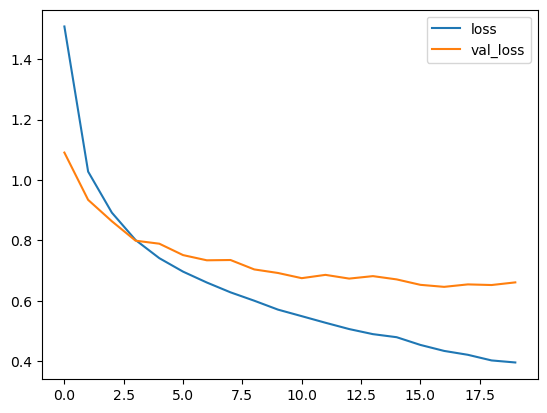

In [23]:
metrics[['loss', 'val_loss']].plot()

<AxesSubplot:>

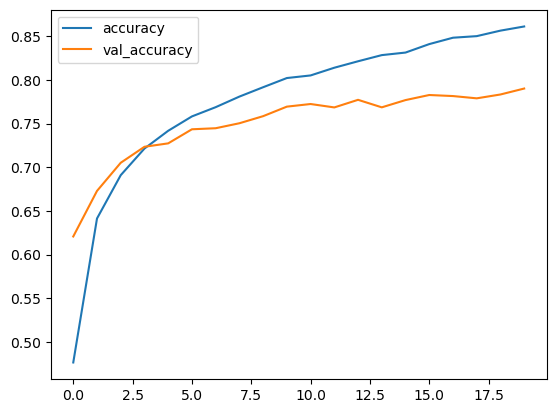

In [24]:
metrics[['accuracy', 'val_accuracy']].plot()

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes):
  y_pred = [np.argmax(x, axis=0) for x in y_pred]
  y_true = [np.argmax(x, axis=0) for x in y_true]
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, xticklabels=classes, yticklabels=classes, annot=True)

In [26]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [27]:
y_pred=model_1.predict(x_test)
y_true=y_test

313/313 [==============================] - 13s 38ms/step


In [28]:
model_1.evaluate(x_test, y_test)

313/313 [==============================] - 13s 39ms/step - loss: 0.6462 - accuracy: 0.7966


[0.6462135910987854, 0.7965999841690063]

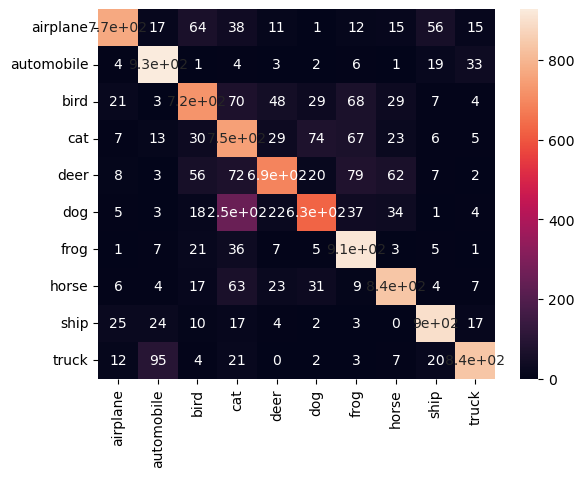

In [29]:
plot_confusion_matrix(y_true, y_pred, classes=class_names)

In [30]:
#Since we have already defined Resnet50 as base_model_2, let us build the sequential model.

model_2 = keras.Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(base_model_2)
model_2.add(Flatten())


#Add the Dense layers along with activation and batch normalization
model_2.add(Dense(4000,activation=('relu'),input_dim=512))
model_2.add(Dense(2000,activation=('relu'))) 
model_2.add(Dropout(.4))
model_2.add(Dense(1000,activation=('relu'))) 
model_2.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_2.add(Dense(500,activation=('relu')))
model_2.add(Dropout(.2))
model_2.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [31]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 4000)              8196000   
                                                                 
 dense_6 (Dense)             (None, 2000)              8002000   
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_7 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)             

In [32]:
#Compile the model 

model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
model_2.fit(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
                      validation_steps=x_test.shape[0]//batch_size,
                      callbacks=[lrr],verbose=1)

Epoch 1/20
273/273 [==============================] - 94s 305ms/step - loss: 1.6711 - accuracy: 0.4124 - val_loss: 2.8478 - val_accuracy: 0.3597 - lr: 0.0010
Epoch 2/20
273/273 [==============================] - 80s 293ms/step - loss: 1.0939 - accuracy: 0.6387 - val_loss: 1.2255 - val_accuracy: 0.6142 - lr: 0.0010
Epoch 3/20
273/273 [==============================] - 80s 293ms/step - loss: 0.9081 - accuracy: 0.7086 - val_loss: 1.0398 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 4/20
273/273 [==============================] - 80s 293ms/step - loss: 0.9173 - accuracy: 0.7072 - val_loss: 1.5894 - val_accuracy: 0.5332 - lr: 0.0010
Epoch 5/20
273/273 [==============================] - 80s 293ms/step - loss: 0.8643 - accuracy: 0.7259 - val_loss: 5.5961 - val_accuracy: 0.3754 - lr: 0.0010
Epoch 6/20
273/273 [==============================] - 80s 293ms/step - loss: 0.9257 - accuracy: 0.6971 - val_loss: 1.3090 - val_accuracy: 0.5770 - lr: 0.0010
Epoch 7/20
273/273 [==============================] 

In [34]:
metrics = pd.DataFrame(model_2.history.history)

<AxesSubplot:>

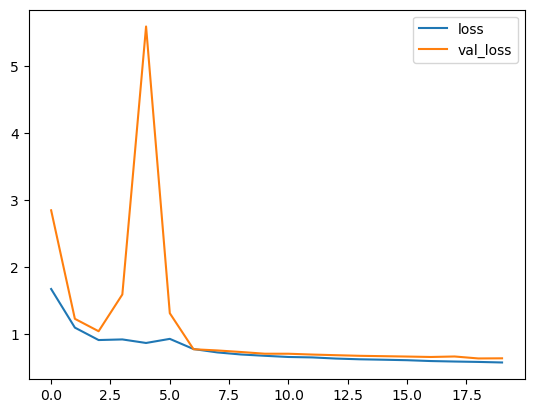

In [35]:
metrics[['loss', 'val_loss']].plot()

<AxesSubplot:>

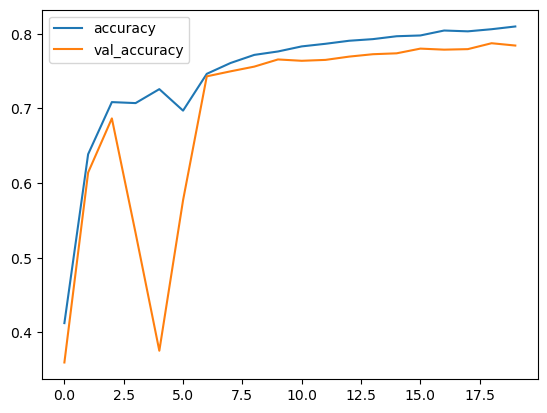

In [36]:
metrics[['accuracy', 'val_accuracy']].plot()

In [37]:
y_pred=model_2.predict(x_test)
y_true=y_test

313/313 [==============================] - 14s 39ms/step


In [38]:
model_2.evaluate(x_test, y_test)

313/313 [==============================] - 14s 42ms/step - loss: 0.6677 - accuracy: 0.7802


[0.667672872543335, 0.7802000045776367]

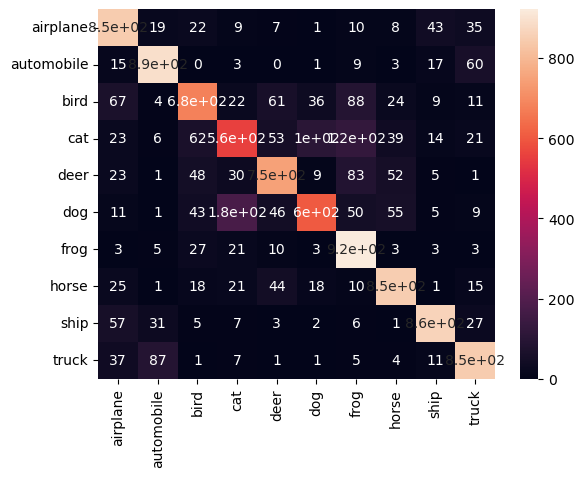

In [39]:
plot_confusion_matrix(y_true, y_pred, classes=class_names)

In [40]:
def predict_classes(model, image):
  image = image.reshape(1, 32, 32, 3)
  prediction = model.predict(image)
  return np.argmax(prediction, axis=1)

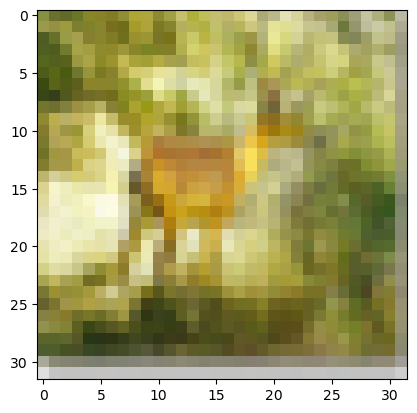

In [41]:
plt.imshow(x_test[500])

In [42]:
def get_class(y):
  return np.argmax(y, axis=0)

In [43]:
get_class(y_test[500])

4

In [44]:
predict_classes(model_1, x_test[500])

1/1 [==============================] - 1s 593ms/step


array([6], dtype=int64)

In [45]:
predict_classes(model_2, x_test[500])

1/1 [==============================] - 0s 488ms/step


array([4], dtype=int64)

In [46]:
from tensorflow.keras.models import load_model

In [47]:
model_1.save("model_sgd.h5")

In [48]:
model_2.save("model_adam.h5")

In [49]:
model_sgd= load_model("model_sgd.h5")
#model_adam=load_model("model_adam.h5") To bigg

In [50]:
fig_class=[ "airplane", "automobile","bird","cat","deer", "dog","frog","horse","ship","truck"]


CORRECT PREDICTIONS For Adam Optimizer


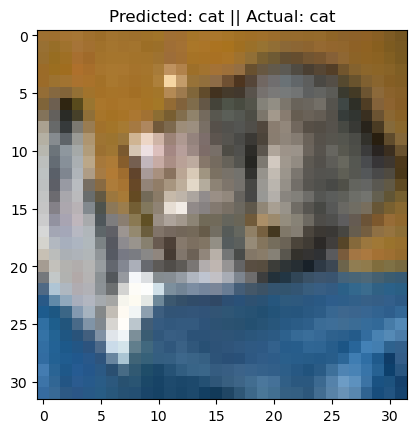

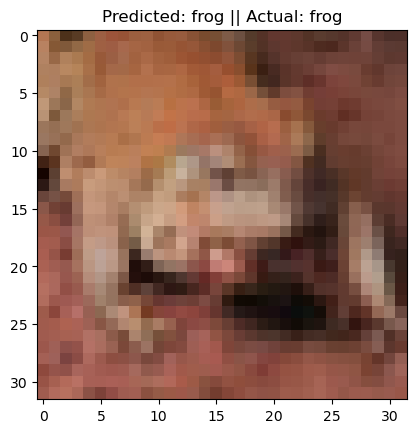

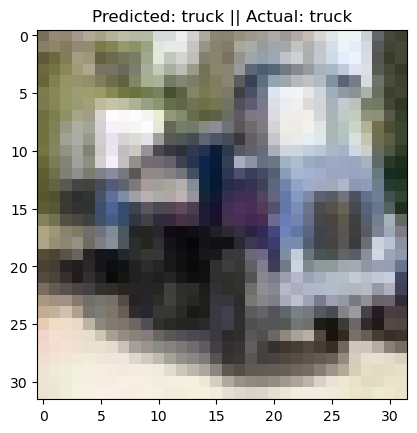

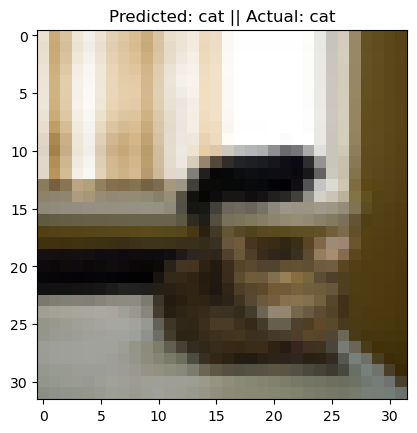

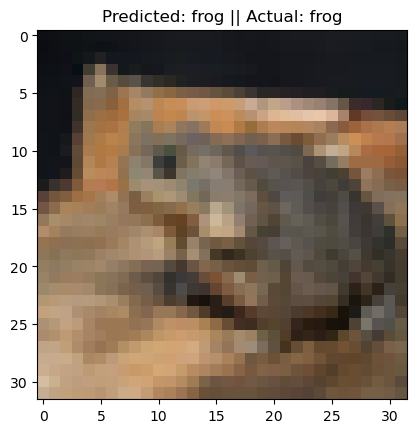

In [51]:
#Lets see which predictions were correct and which were incorrect
count=0
print("CORRECT PREDICTIONS For Adam Optimizer")

#Correct Predictions:
for i in range(0,10000):
    #to randomly check our sample data
    for_random=np.random.binomial(n=1,p=0.1,size=[1])
    
    #our test datas
   # test_image=test_image.resize((32,32))
    
    test_image=x_test[i].reshape(1,32,32,3)
    
    #gives back the prediction
    predict_image=model_2.predict(test_image,verbose=0)
    prediction_value=int(np.argmax(predict_image,axis=1))
    
    #plotting
    index=(np.where(y_test[i]==1))[0][0]
    if(index==prediction_value and for_random):
            plt.title(f"Predicted: {fig_class[prediction_value]} || Actual: {fig_class[index]}")
            plt.imshow(x_test[i])
            plt.show()
            count+=1
    if count == 5:
        break

CORRECT PREDICTIONS For Sgd Optimizer


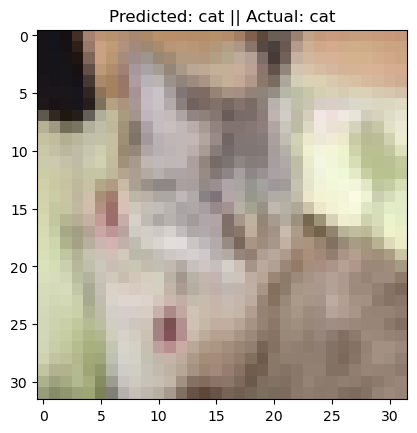

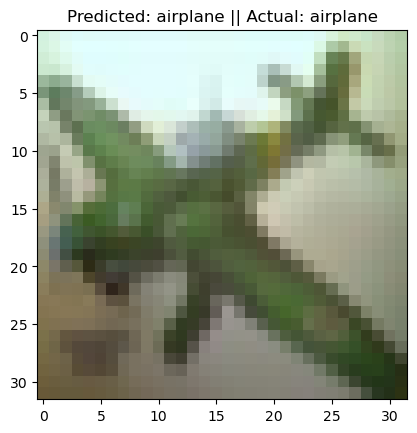

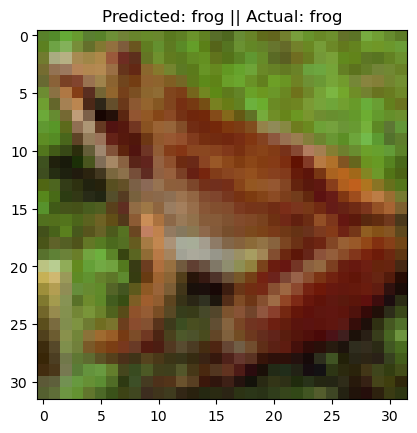

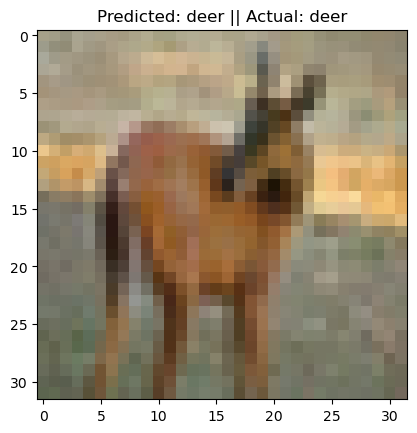

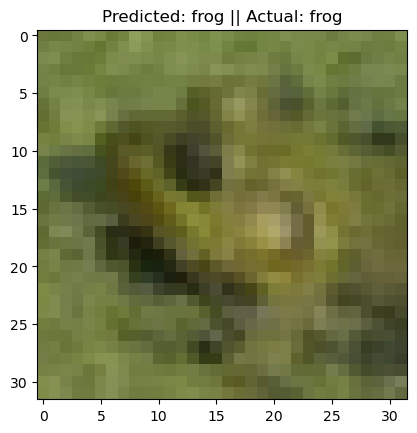

In [52]:
count=0
print("CORRECT PREDICTIONS For Sgd Optimizer")

#Correct Predictions:
for i in range(0,10000):
    #to randomly check our sample data
    for_random=np.random.binomial(n=1,p=0.1,size=[1])
    
    #our test datas
   # test_image=test_image.resize((32,32))
    
    test_image=x_test[i].reshape(1,32,32,3)
    
    #gives back the prediction
    predict_image=model_1.predict(test_image,verbose=0)
    prediction_value=int(np.argmax(predict_image,axis=1))
    
    #plotting
    index=(np.where(y_test[i]==1))[0][0]
    if(index==prediction_value and for_random):
            plt.title(f"Predicted: {fig_class[prediction_value]} || Actual: {fig_class[index]}")
            plt.imshow(x_test[i])
            plt.show()
            count+=1
    if count == 5:
        break

INCORRECT PREDICTIONS for adam


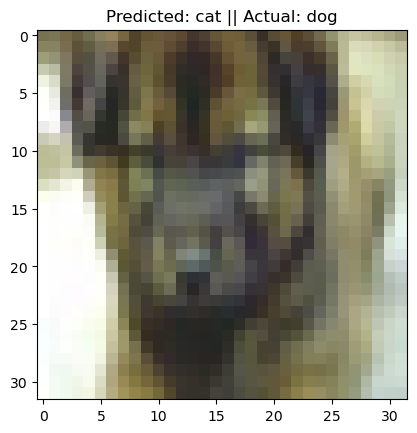

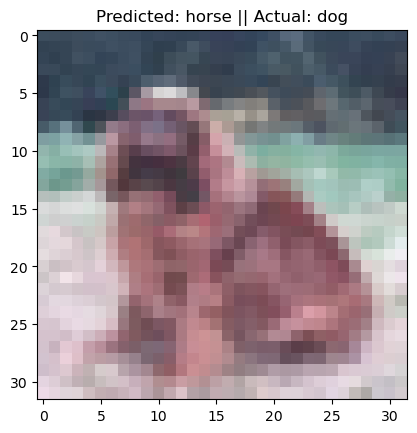

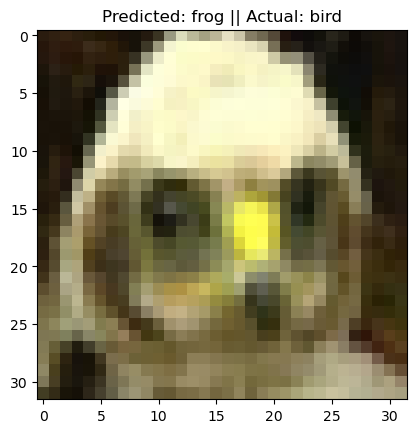

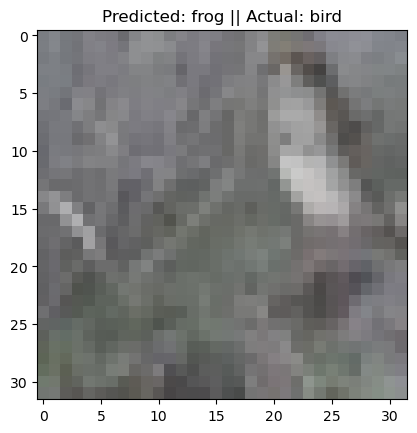

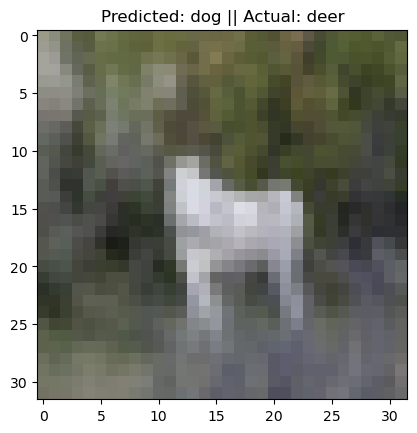

In [53]:
#Lets see which predictions were incorrect 
count=0
print("INCORRECT PREDICTIONS for adam")
#InCorrect Predictions:
for i in range(0,10000):
    #to randomly check our sample data
    for_random=np.random.binomial(n=1,p=0.1,size=[1])
    
    #our test datas
    test_image=x_test[i].reshape(1,32,32,3)
    #gives back the prediction
    predict_image=model_2.predict(test_image,verbose=0)
    prediction_value=np.argmax(predict_image,axis=1)
    index=(np.where(y_test[i]==1))[0][0]
    
    #plotting
    if(int(index)!=prediction_value and for_random):
            plt.title(f"Predicted: {fig_class[int(prediction_value)]} || Actual: {fig_class[index]}")
            plt.imshow(x_test[i])
            plt.show()
            count+=1
    if count == 5:
        break
            

INCORRECT PREDICTIONS For SGD Optimizer


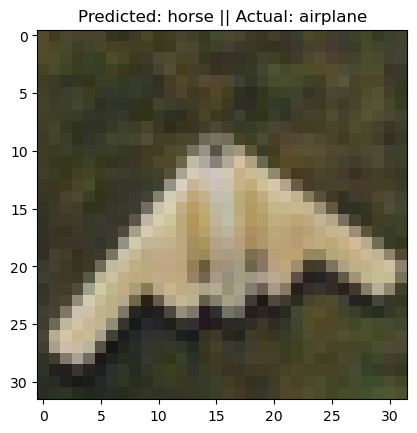

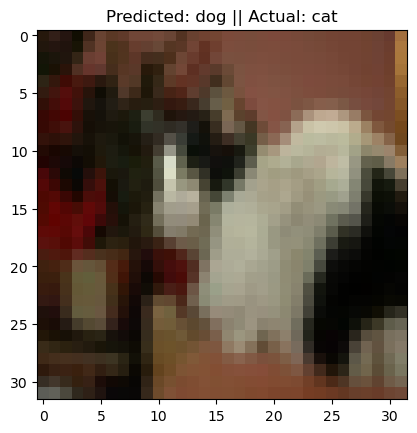

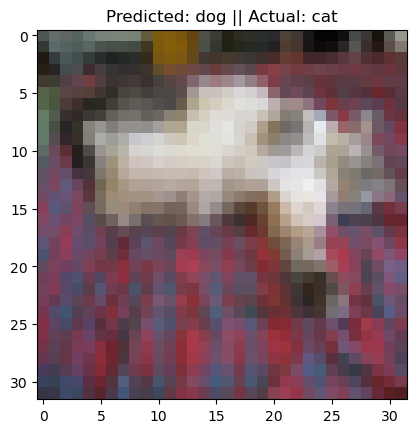

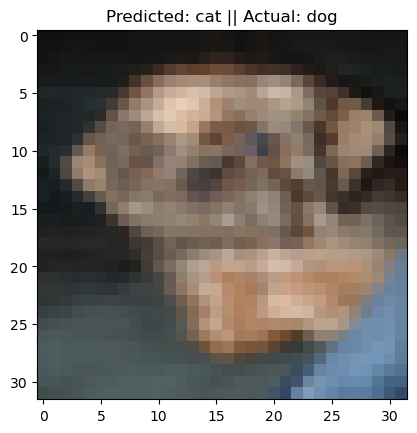

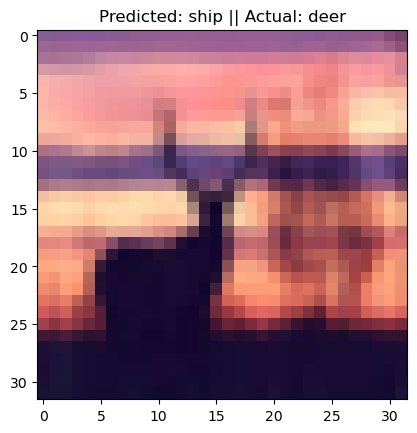

In [54]:
count=0
print("INCORRECT PREDICTIONS For SGD Optimizer")

#Correct Predictions:
for i in range(0,10000):
    #to randomly check our sample data
    for_random=np.random.binomial(n=1,p=0.1,size=[1])
    
    #our test datas
   # test_image=test_image.resize((32,32))
    
    test_image=x_test[i].reshape(1,32,32,3)
    
    #gives back the prediction
    predict_image=model_1.predict(test_image,verbose=0)
    prediction_value=int(np.argmax(predict_image,axis=1))
    
    #plotting
    index=(np.where(y_test[i]==1))[0][0]
    if(index!=prediction_value and for_random):
            plt.title(f"Predicted: {fig_class[prediction_value]} || Actual: {fig_class[index]}")
            plt.imshow(x_test[i])
            plt.show()
            count+=1
    if count == 5:
        break

In [55]:

#predicting on external pictures
from PIL import Image
import matplotlib.image as image
from numpy import array


In [56]:
#Predicting Exteranal Img with adam optimizer
def predict_externalImg_classes(image,index):
    #image_resize=image.resize((32,32))
    image_reshape=image.reshape(1,32,32,3)
    predict_image=model_2.predict(image_reshape,verbose=0)
    prediction_value=int(np.argmax(predict_image,axis=1))
    plt.title(f"Predicted: {fig_class[prediction_value]} || Actual: {fig_class[index]}")
    plt.imshow(image)
    plt.show()
    

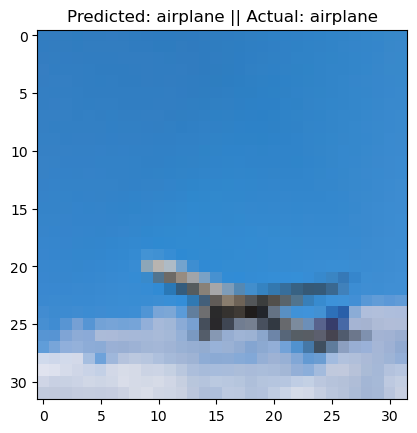

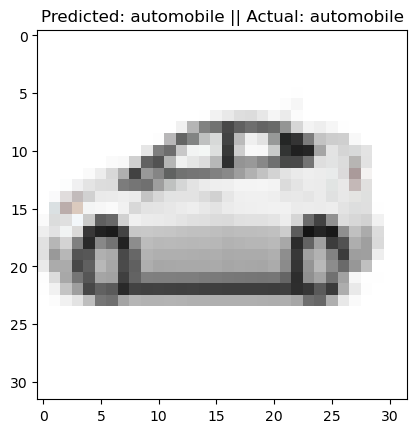

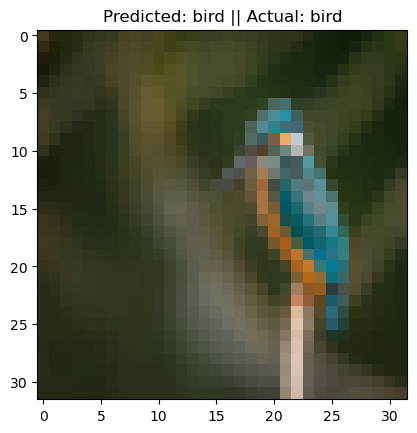

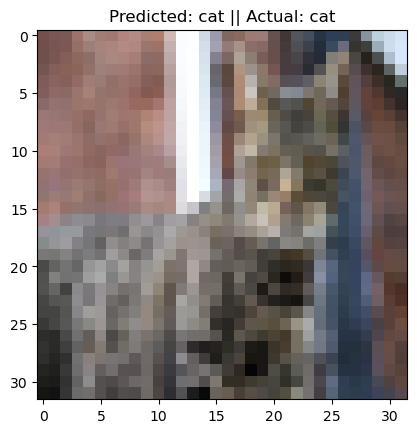

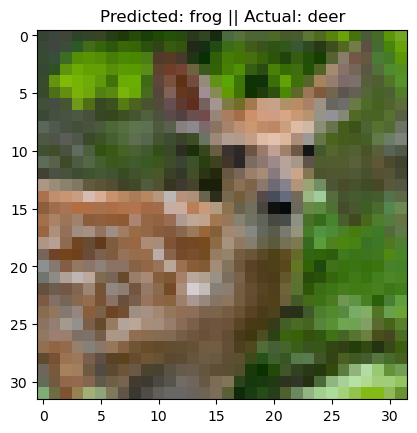

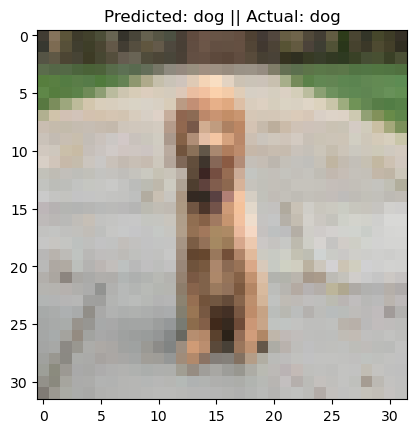

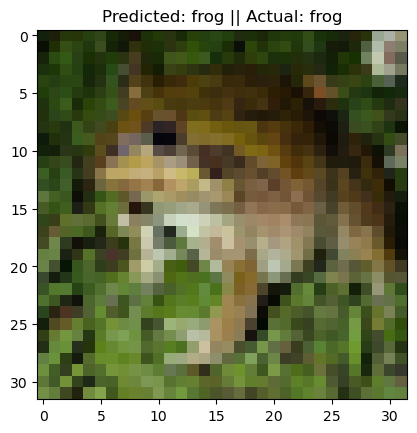

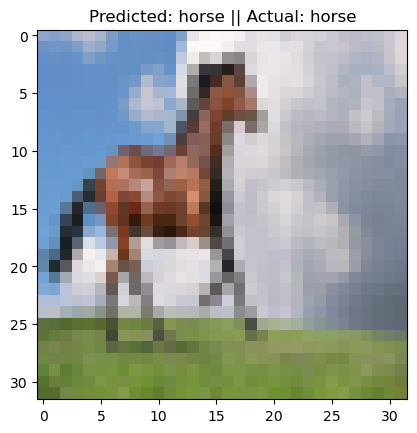

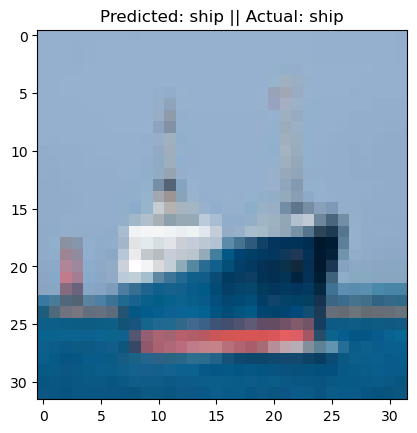

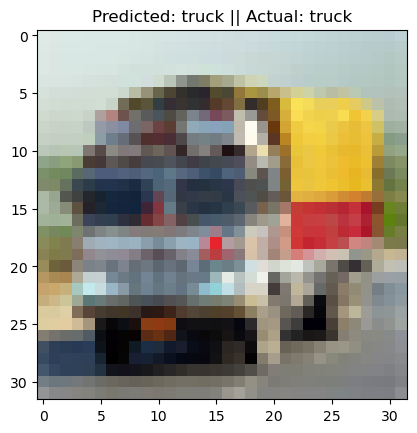

In [57]:
#Predicting External Image
for i in range (0,10):
    image=Image.open(rf"photo\{i}.jfif")
    image=image.resize((32,32))
    image_ar=array(image)
    predict_externalImg_classes(image_ar,i)

In [58]:
#Predicting Exteranal Img with sgd optimizer
def predict_externalImg_classes(image,index):
    #image_resize=image.resize((32,32))
    image_reshape=image.reshape(1,32,32,3)
    predict_image=model_1.predict(image_reshape,verbose=0)
    prediction_value=int(np.argmax(predict_image,axis=1))
    plt.title(f"Predicted: {fig_class[prediction_value]} || Actual: {fig_class[index]}")
    plt.imshow(image)
    plt.show()
    

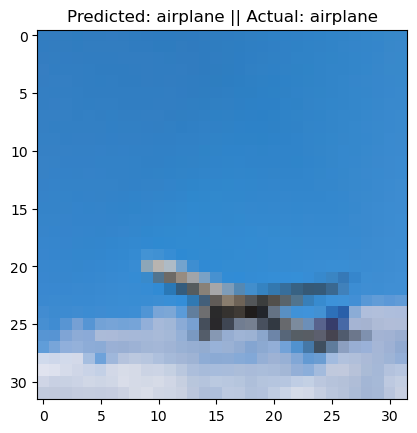

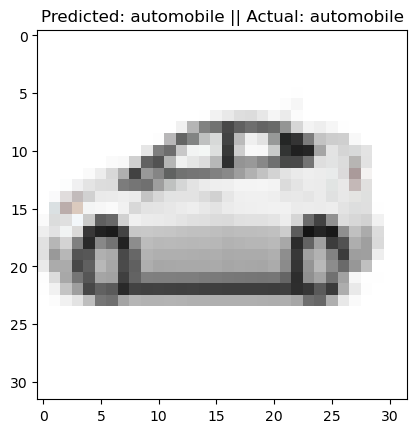

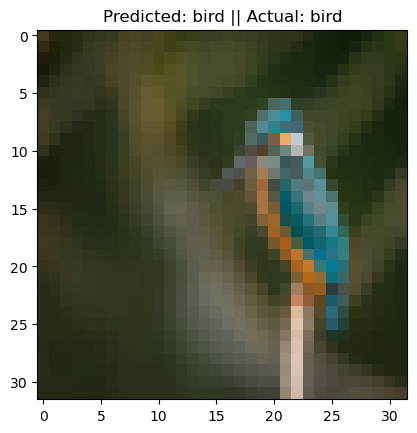

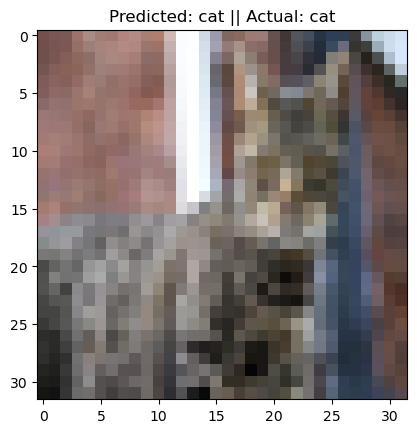

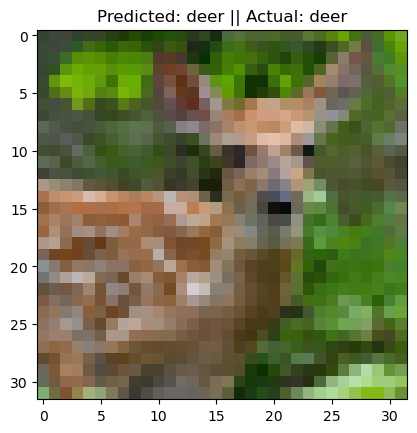

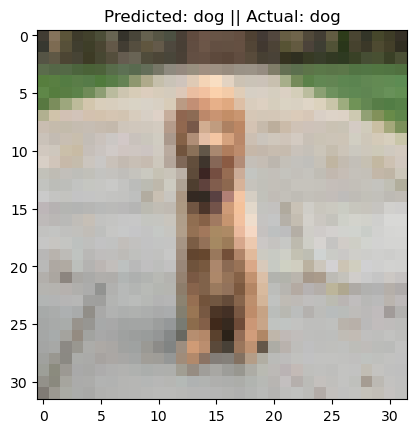

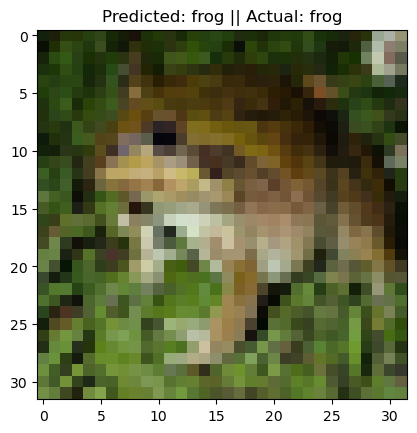

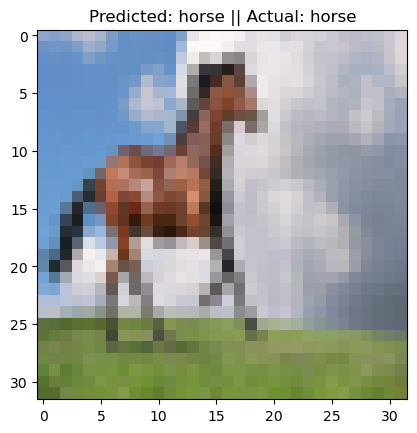

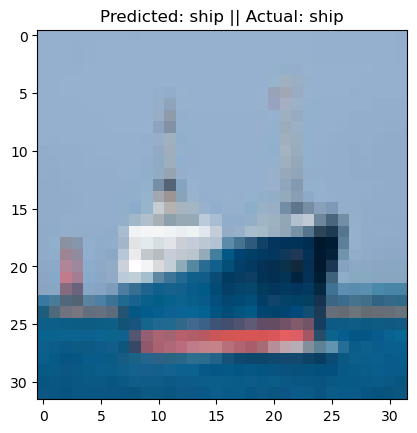

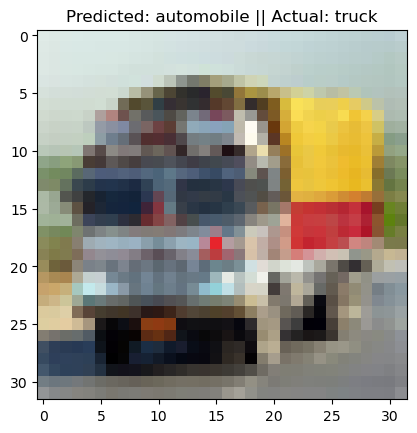

In [59]:
#Predicting External Image
for i in range (0,10):
    image=Image.open(rf"photo\{i}.jfif")
    image=image.resize((32,32))
    image_ar=array(image)
    predict_externalImg_classes(image_ar,i)